In [1]:
__author__ = 'Knut Olsen <kolsen@noao.edu>' # single string; emails in <>
__version__ = '20200330' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['des_dr1']  # enter used datasets by hand
__keywords__ = ['LMC','Healpix map','plot:cmd']

# Exploring DES DR1

*Knut Olsen & the NOAO Data Lab Team*

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
import pandas as pd
from io import StringIO
from astropy import units as u
from getpass import getpass

%matplotlib inline

# Datalab and related imports
from dl import authClient as ac, queryClient as qc
from dl import storeClient as sc

<a class="anchor" id="density"></a>
# Make an object density map


By using GROUP BY, we can aggregate in specified bins. In this next query, the GROUP BY clause tells the database to aggregate the results by the values in the nest4096 column, and return the average RA and Dec of objects in those groups, as well as the nest4096 value itself and the count of the number of objects in the group.

In [3]:
# select point sources with g-r<0.75, g>19.5, and gerr<0.2
desquery = """SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb
           FROM des_dr1.main
           WHERE wavg_spread_model_i>(-90) AND mag_auto_g<90
           AND (mag_auto_g-mag_auto_r)<0.75 AND mag_auto_g>19.5 AND magerr_auto_g<0.2
           
           AND (
           (
           (wavg_spread_model_i + 3*wavg_spreaderr_model_i)<0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)<0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)<0.003
            ) OR (
            (wavg_spread_model_i + 3*wavg_spreaderr_model_i)>=0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)<0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)<0.003
            ) OR (
            (wavg_spread_model_i + 3*wavg_spreaderr_model_i)<0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)>=0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)<0.003
            ) OR (
            (wavg_spread_model_i + 3*wavg_spreaderr_model_i)<0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)<0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)>=0.003
            )
           )

           GROUP BY nest4096
        """

In [4]:
%%time
# This query should take about 180 sec
try:
    df_desdensity = qc.query(sql=desquery,fmt='pandas',timeout=600) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 6.49 s, sys: 1.89 s, total: 8.38 s
Wall time: 7min 19s


In [5]:
df_desdensity

,ra0,dec0,nest4096,nb
0,44.980361,0.047813,11,1
1,44.998287,0.066371,15,1
2,45.036813,0.098710,30,1
3,44.939822,0.059274,34,1
4,44.952358,0.086211,44,2
...,...,...,...,...
7972669,316.271362,-1.258900,201315612,2
7972670,316.225781,-1.265289,201315621,1
7972671,316.237055,-1.260298,201315632,1
7972672,316.310203,-1.258636,201315648,1


In [6]:
print(np.sum(df_desdensity['nb'])) # print total counts

11531107


### Making the Healpix map
A Healpix map is simply a one-dimensional array with number of elements set by the NSIDE parameter, which is the number of times the base Healpixels are split.  We can visualize it as a map using the <tt>healpy</tt> library.

In [7]:
tmap = np.zeros(hp.nside2npix(4096))

### Populating the Healpix map
Now we set the elements of our Healpix map to the number of objects returned by the query, calculate the center of the RA and Dec distribution of the objects, and use healpy's orthview to visualize the output.  We'll use a logarithmic version of the map for the visualization.  We'll also overplot the location of the Galactic plane.  Healpy allows you to mix equatorial (coord='C') and Galactic (coord='G') coordinates.

In [8]:
tmap[df_desdensity['nest4096']]=df_desdensity['nb']

/data0/sw/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/data0/sw/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/data0/sw/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin
/data0/sw/anaconda3/lib/python3.7/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/data0/sw/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:425: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


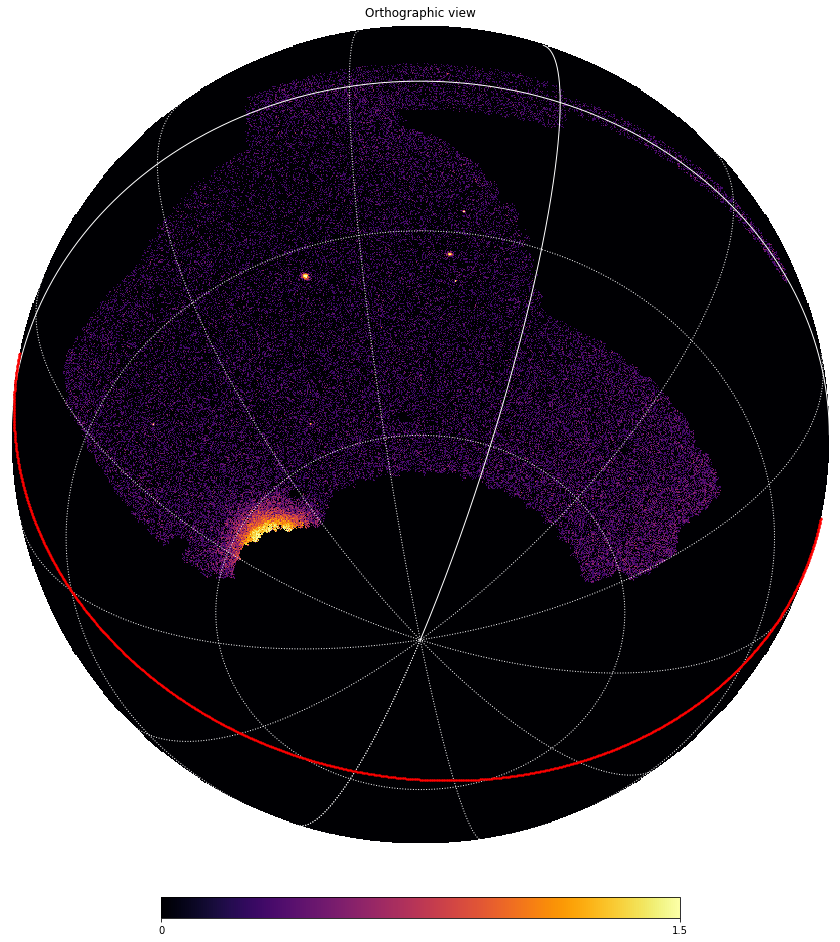

In [9]:
fig = plt.figure(figsize=(15,15))
lon=np.arange(3600)/10
lat=np.zeros(3600)
hp.orthview(np.log10(tmap+1),nest=True,fig=1,rot=(20,-60,0),min=0,max=1.5,cmap='inferno',coord='C',half_sky=True,norm='linear',notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

An NSIDE 4096 healpix map is pretty high resolution (~1 arcmin).  If we downgrade the resolution to NSIDE = 512 or 256, it helps bring out low surface brightness features.

In [11]:
map512 = hp.ud_grade(tmap,512,order_in='NESTED',order_out='NESTED')
map256 = hp.ud_grade(tmap,256,order_in='NESTED',order_out='NESTED')

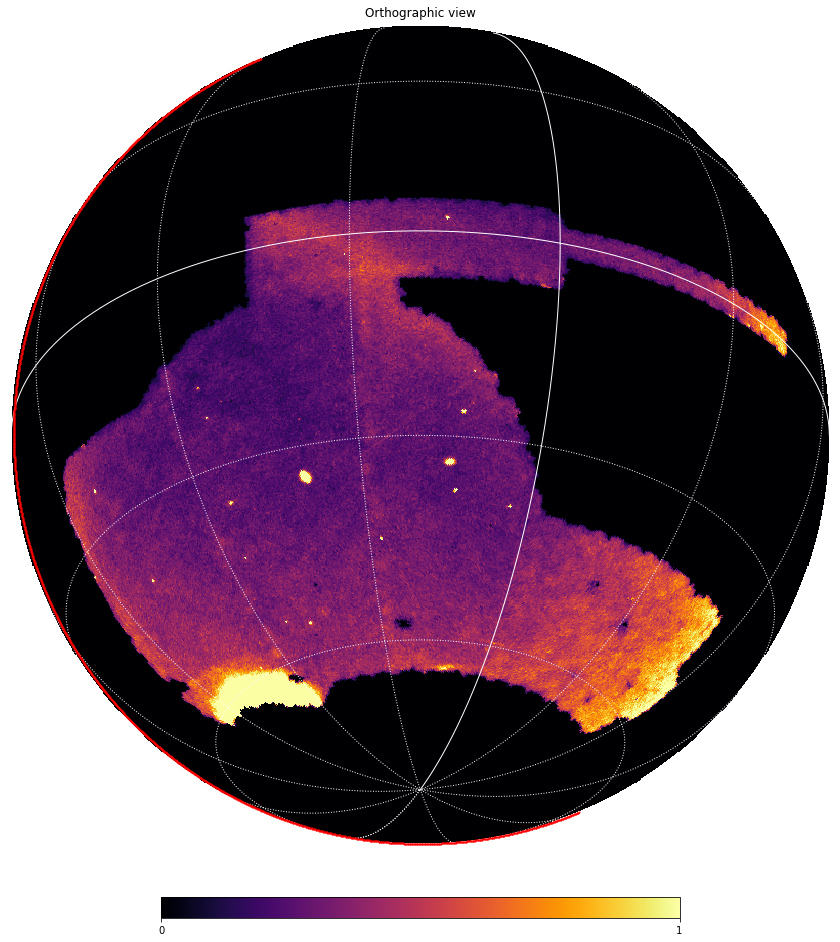

In [12]:
fig = plt.figure(figsize=(15,15))
lon=np.arange(3600)/10
lat=np.zeros(3600)
#hp.orthview(np.log10(map256+map256.min()+0.001),nest=True,fig=1,rot=(180,-70,0),min=-1,max=0.4,cmap='inferno',coord='C',half_sky=True,norm='linear',notext=True)
hp.orthview((map256+map256.min()+0.001),nest=True,fig=1,rot=(20,-30,0),min=0,max=1.,cmap='inferno',coord='C',
            half_sky=True,norm='linear',notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)



In [12]:
# approximate depth as 95% of the cumulative distribution of point sources with S/N>5, i.e. magnitude error < 0.2
compquery = """SELECT ring256,count(ring256) as nb, percentile_disc(0.95) WITHIN GROUP (ORDER BY mag_auto_g) AS p
           FROM des_dr1.main
           WHERE wavg_spread_model_i>(-90) AND mag_auto_g<30 AND magerr_auto_g<0.2
           
           AND (
           (
           (wavg_spread_model_i + 3*wavg_spreaderr_model_i)<0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)<0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)<0.003
            ) OR (
            (wavg_spread_model_i + 3*wavg_spreaderr_model_i)>=0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)<0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)<0.003
            ) OR (
            (wavg_spread_model_i + 3*wavg_spreaderr_model_i)<0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)>=0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)<0.003
            ) OR (
            (wavg_spread_model_i + 3*wavg_spreaderr_model_i)<0.005 AND
            (wavg_spread_model_i + wavg_spreaderr_model_i)<0.003 AND
            (wavg_spread_model_i - wavg_spreaderr_model_i)>=0.003
            )
           )

           GROUP BY ring256
        """

In [13]:
%%time
try:
    df_comp = qc.query(sql=compquery,fmt='pandas',timeout=600) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 820 ms, sys: 23 ms, total: 843 ms
Wall time: 1min 18s


Create and plot the depth map

In [14]:
cmap = np.zeros(hp.nside2npix(256))
cmap[df_comp['ring256']]=df_comp['p']

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


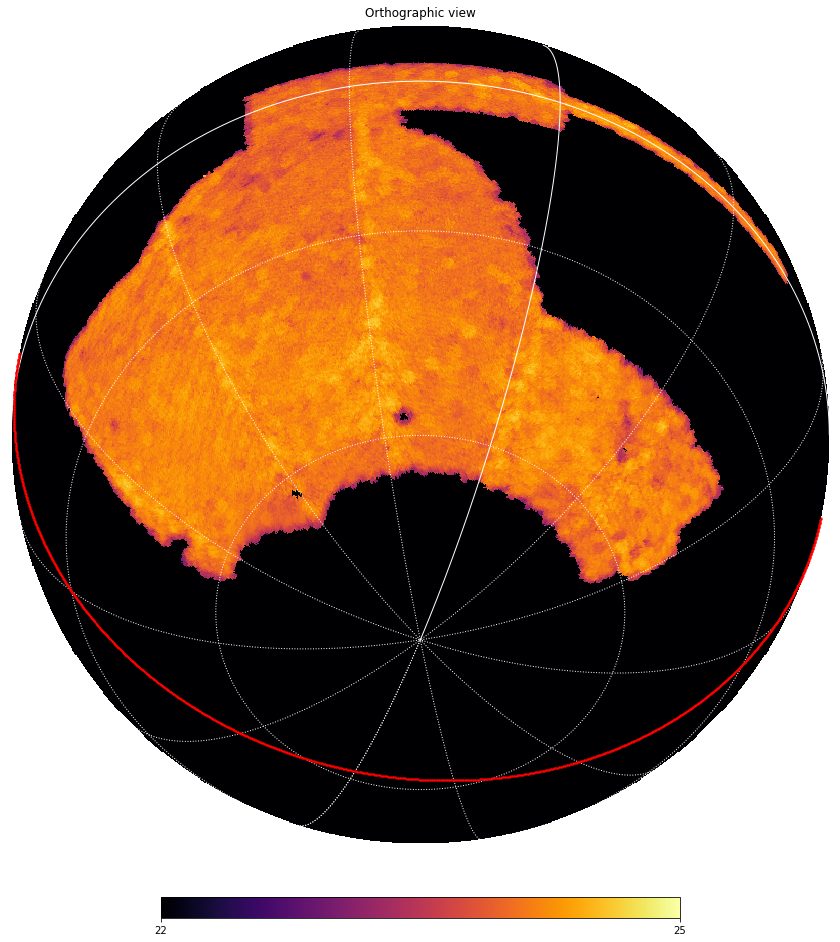

In [15]:
fig = plt.figure(figsize=(15,15))
lon=np.arange(3600)/10
lat=np.zeros(3600)
#hp.orthview(np.log10(map256+map256.min()+0.001),nest=True,fig=1,rot=(180,-70,0),min=-1,max=0.4,cmap='inferno',coord='C',half_sky=True,norm='linear',notext=True)
hp.orthview(cmap,nest=False,fig=1,rot=(20,-60,0),min=22,max=25.,cmap='inferno',coord='C',
            half_sky=True,norm='linear',notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)



Create a weight map from the magnitude depth map

In [16]:
gt0 = cmap>0
mag0 = np.median(cmap[gt0])
cmap2 = cmap.copy()
cmap2[gt0] = cmap2[gt0]-mag0
wgtmap = 10**(-0.4*cmap2)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


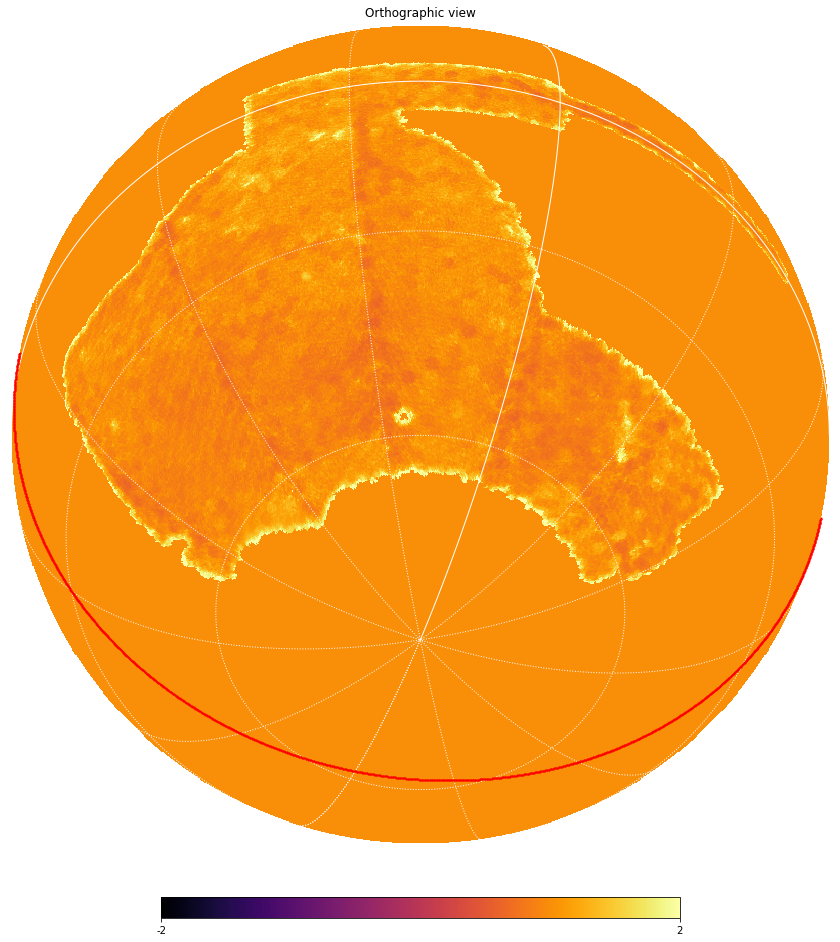

In [17]:
fig = plt.figure(figsize=(15,15))
lon=np.arange(3600)/10
lat=np.zeros(3600)
#hp.orthview(np.log10(map256+map256.min()+0.001),nest=True,fig=1,rot=(180,-70,0),min=-1,max=0.4,cmap='inferno',coord='C',half_sky=True,norm='linear',notext=True)
hp.orthview(wgtmap,nest=False,fig=1,rot=(20,-60,0),min=-2,max=2.,cmap='inferno',coord='C',
            half_sky=True,norm='linear',notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)



Reorder the weightmap to Nested format

In [18]:
wgtmapn = hp.reorder(wgtmap,r2n=True)

See if the weight map helps reduce the artifacts in the density map.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


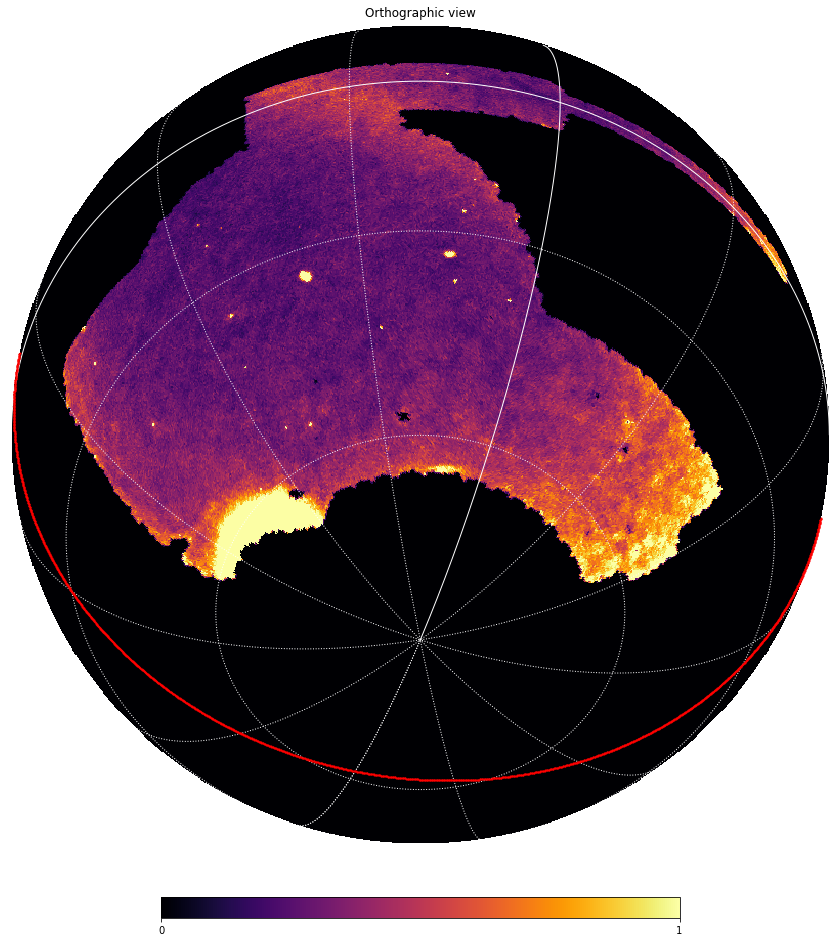

In [19]:
fig = plt.figure(figsize=(15,15))
lon=np.arange(3600)/10
lat=np.zeros(3600)
#hp.orthview(np.log10(map256+map256.min()+0.001),nest=True,fig=1,rot=(180,-70,0),min=-1,max=0.4,cmap='inferno',coord='C',half_sky=True,norm='linear',notext=True)
hp.orthview((map256*wgtmapn),nest=True,fig=1,rot=(20,-60,0),min=0,max=1.,cmap='inferno',coord='C',
            half_sky=True,norm='linear',notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

